# 1. Integrácia dát (3b)

- Integrácia datasetu - vhodne zakomponujte zvolené informácie o počasí.
- Sampling – vytvorenie vzorky z datasetu (veľkosti napr. 10%) pri zachovaní rozloženia cieľového atribútu.
- Rozdelenie datasetu na trénovaciu a testovaciu množinu (napr. v pomere 60/40).

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

In [2]:
def read_csv_files(spark: SparkSession, file_paths: list[str], infer_schema:bool=True, header:bool=True, on:str="id", how:str="inner") -> DataFrame:
    if len(file_paths) == 0:
        schema = StructType([
            StructField("id", IntegerType(), True),
            StructField("name", StringType(), True)
        ])
        df = spark.createDataFrame([],schema)
    else:
        df = spark.read.csv(file_paths[0], header=header, inferSchema=infer_schema)
        for idx in range(1,len(file_paths)):
            file = spark.read.csv(file_paths[idx], header=header, inferSchema=infer_schema)
            file = file.withColumnRenamed("Vehicle_Reference", f"Vehicle_Reference_{idx}")
            df = df.join(file, on=on, how=how)
            print(df.columns)
            print(f'df{idx}--------------')
    return df

In [3]:
def sample_by_percent(df: DataFrame, label: str, percent: float) -> DataFrame:
    fractions = df.select(label).distinct().rdd.map(lambda r: (r[0], percent)).collectAsMap()
    return df.stat.sampleBy(label, fractions, seed=42)

In [4]:
spark = SparkSession.builder.appName("CarAccidents").getOrCreate()

file_list = [
    "../datalab/TSVD/dataset/CarAccidents/Accidents.csv",
    "../datalab/TSVD/dataset/CarAccidents/Casualties.csv",
    "../datalab/TSVD/dataset/CarAccidents/Vehicles.csv"
]

df = read_csv_files(spark, file_list, on="Accident_Index",how="inner")

['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location', 'Vehicle_Reference_1', 'Casualty_Reference', 'Casualty_Class', 'Sex_of_Casualty', 'Age_of_Casualty', 'Age_Band_of_Casualty', 'Casualty_Severity', 'Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger', 'Bus_or_Coach_Passenger', 'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type', 

In [5]:

sampled_data = sample_by_percent(df,"Accident_Severity",0.1)
print(f"Percent for sample data: {(sampled_data.count()/df.count())*100}")
# sampled_data

Percent for sample data: 10.011281387948904


# 2. Predspracovanie (7b)

- Transformácia nominálnych atribútov na numerické
- Transformácia numerických atribútov na nominálne
- Vypočítanie pomerového kritéria – informačného zisku voči cieľovému atribútu (klasifikačná úloha), pre nominálne atribúty
- Vypočítanie štatistík pre numerické atribúty
- Vytvorenie histogramov pre nominálne atribúty
- Spracovanie chýbajúcich hodnôt (napr. ich nahradenie priemermi, atď.)

In [12]:
from pyspark.sql import functions as F
from pyspark.sql.functions import approx_count_distinct
from pyspark.sql.types import FloatType, DoubleType
from pyspark.sql.functions import isnan, isnull

sampled_data = sampled_data.replace(-1, None)
sampled_data = sampled_data.dropna().drop('Date').drop('Accident_Index')

agg_result = sampled_data.agg(*[
    F.approx_count_distinct(c).alias(c)
    for c in sampled_data.columns
]).first().asDict()

numeric_binning = []
# manually added bcz the dataset is already 'cleaned'
numeric = ['Longitude','Latitude', 'Number_of_Vehicles', 'Number_of_Casualties', 'Speed_Limit', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Age_of_Casualty', 'Age_of_Driver', 'Engine_Capacity_(CC)']
to_onehot = []
sd = sampled_data
for col, count in agg_result.items():
    col_type = sd.schema[col].dataType
    if isinstance(col_type, StringType):
        if count <= 10:
            to_be_str_indexed.append(col)
            print(f"{col}: {count} NEED TO STRING INDEX")
        else:
            print(f"{col}: {count} UNUSED")
    elif isinstance(col_type, (IntegerType, FloatType, DoubleType)):
        if col in numeric:
            print(f"{col}: {count} NUMERIC")
        elif count <= 10:
            to_onehot.append(col)
            print(f"{col}: {count} TO ONEHOT")
        else:
            numeric_binning.append(col)
            print(f"{col}: {count} TO BE BINNED")
    else:
        print(f"{col}: {count} UNUSED")

print(len(to_be_str_indexed))
print(len(to_onehot))


Location_Easting_OSGR: 32752 NUMERIC
Location_Northing_OSGR: 32653 NUMERIC
Longitude: 38388 NUMERIC
Latitude: 40798 NUMERIC
Police_Force: 43 TO BE BINNED
Accident_Severity: 3 TO ONEHOT
Number_of_Vehicles: 10 NUMERIC
Number_of_Casualties: 21 NUMERIC
Day_of_Week: 7 TO ONEHOT
Time: 1377 UNUSED
Local_Authority_(District): 343 TO BE BINNED
Local_Authority_(Highway): 165 UNUSED
1st_Road_Class: 6 TO ONEHOT
1st_Road_Number: 3076 TO BE BINNED
Road_Type: 6 TO ONEHOT
Speed_limit: 6 TO ONEHOT
Junction_Detail: 8 TO ONEHOT
Junction_Control: 4 TO ONEHOT
2nd_Road_Class: 6 TO ONEHOT
2nd_Road_Number: 3061 TO BE BINNED
Pedestrian_Crossing-Human_Control: 3 TO ONEHOT
Pedestrian_Crossing-Physical_Facilities: 6 TO ONEHOT
Light_Conditions: 5 TO ONEHOT
Weather_Conditions: 9 TO ONEHOT
Road_Surface_Conditions: 5 TO ONEHOT
Special_Conditions_at_Site: 8 TO ONEHOT
Carriageway_Hazards: 6 TO ONEHOT
Urban_or_Rural_Area: 2 TO ONEHOT
Did_Police_Officer_Attend_Scene_of_Accident: 3 TO ONEHOT
LSOA_of_Accident_Location: 189

In [37]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, count, mean, when, isnull, isnan, lit
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, QuantileDiscretizer, Imputer, ChiSqSelector, OneHotEncoder
from pyspark.ml.stat import ChiSquareTest
from pyspark.mllib.stat import Statistics
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def preprocess_data(df: DataFrame, cols) -> DataFrame:
    numerical, numerical_binning, to_onehot = cols
    # print(numerical)
    if 'Accident_Severity' in numerical:
        numerical.remove('Accident_Severity')
        
    to_keep = ['Accident_Severity']
    stages = []
    
    # numerical to nominal (Binning)
    for num_col in numerical_binning:
        to_keep.append(f'{num_col}_category')
        discretizer = QuantileDiscretizer(numBuckets=10, 
                                        inputCol=num_col, 
                                        outputCol=num_col+"_category",
                                        handleInvalid="keep",
                                        relativeError=0.01)
        stages.append(discretizer)

    # nominal to numerical -> not needed, as the dataset already has the originally nominal columns converted to numerical indexes
    
    for num_col in numerical:
        to_keep.append(num_col)

    for col in to_onehot:
        to_keep.append(col)
    
    df.cache()  
    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(df)
    wo_onehot_df = pipeline_model.transform(df).select(to_keep)

    # one hot encoding
    for num_col in numerical_binning:
        to_keep.append(f'{num_col}_encoded')
        to_keep.remove(f'{num_col}_category')
        stages.append(OneHotEncoder(
            inputCol=f"{num_col}_category",
            outputCol=f"{num_col}_encoded"
        ))
    
    for cat_col in to_onehot:
        to_keep.append(f'{cat_col}_encoded')
        to_keep.remove(f'{cat_col}')
        stages.append(OneHotEncoder(
            inputCol=f"{cat_col}",
            outputCol=f"{cat_col}_encoded"
         ))

    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(df)
    onehot_df = pipeline_model.transform(df).select(to_keep)
    
    df.unpersist()
    
    return wo_onehot_df, onehot_df

def calculate_information_gain(df: DataFrame, cat_idx_cols, target_col: str = "Accident_Severity"):
    to_calc = []
    for col in df.columns:
        if col == 'Accident_Severity':
            continue
        elif col in cat_idx_cols:
            to_calc.append(col)
        elif col.endswith("_category"):
            to_calc.append(col)
        else:
            pass
    # print(to_calc)
    
    assembler = VectorAssembler(
        inputCols=to_calc,
        outputCol="features")
    
    feature_df = assembler.transform(df)
    # print('feature_df cols')
    # feature_df.printSchema()
    
    selector = ChiSqSelector(numTopFeatures=10, 
                           featuresCol="features", 
                           outputCol="selectedFeatures", 
                           labelCol=target_col)
    
    model = selector.fit(feature_df)
    result = model.transform(feature_df)

    best_cols_indices = model.selectedFeatures
    all_categorical_cols = [col for idx, col in enumerate(to_calc) if idx in best_cols_indices]  
    
    ig_results = []
    print('starting tests now')
    for col in all_categorical_cols:
        assembler = VectorAssembler(inputCols=[col], outputCol="feature_vec")
        df_vec = assembler.transform(df)
        
        chi2 = ChiSquareTest.test(df_vec, "feature_vec", target_col).head()
        
        ig_results.append({
            "Feature": str(col),
            "Chi2_Statistic": float(chi2.statistics.toArray()[0]),
            "pValue": float(chi2.pValues[0]),
            "DegreesOfFreedom": chi2.degreesOfFreedom,
            "Information_Gain": float(chi2.statistics.toArray()[0]) / (2 * df_vec.count())
        })
    
    ig_df = spark.createDataFrame(ig_results).orderBy("information_gain", ascending=False)
    ig_df.show(truncate=False)
    
    return model, result

def calculate_numerical_stats(df: DataFrame, cols):
    numerical_cols = cols
    print(numerical_cols)
    
    stats = df.select(numerical_cols).describe().toPandas().set_index('summary')
    print("Basic statistics:")
    print(stats)
    
    numerical_df = df.select(numerical_cols)
    corr_matrix = Statistics.corr(numerical_df.rdd.map(lambda row: [float(x) for x in row]), method="pearson")
    corr_df = pd.DataFrame(corr_matrix, columns=numerical_cols, index=numerical_cols)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_df, 
        annot=True,      
        fmt=".2f",       
        cmap="coolwarm",  
        vmin=-1,         
        vmax=1,          
        linewidths=0.5,
        square=True
    )
    
    plt.title("Correlation Matrix", fontsize=16)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
    plt.tight_layout()
    plt.show()
    # print("\nCorrelation matrix:")
    # print(corr_df)
    
    return stats, corr_df

def create_histograms(df: DataFrame, nominal_cols: list):
    for col_name in nominal_cols:
        if col_name in df.columns:
            value_counts = df.groupBy(col_name).count().orderBy("count", ascending=False).toPandas()
            
            plt.figure(figsize=(5, 3))
            plt.bar(value_counts[col_name].astype(str), value_counts["count"])
            plt.title(f"Histogram of {col_name}")
            plt.xlabel(col_name)
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.show()

In [35]:
%matplotlib inline
pre_cols = (numeric, numeric_binning, to_onehot)
wo_onehot_df, onehot_df = preprocess_data(sd, pre_cols)
print('preprocessing done')

preprocessing done


In [39]:
print("Information Gain table:")
ig_model, results = calculate_information_gain(wo_onehot_df, to_onehot)

Information Gain table:
+------------------+----------------+-----------------------------------+---------------------+------+
|Chi2_Statistic    |DegreesOfFreedom|Feature                            |Information_Gain     |pValue|
+------------------+----------------+-----------------------------------+---------------------+------+
|1604.059834180801 |[6]             |Casualty_Type_category             |0.016712090122948064 |0.0   |
|631.6774280259057 |[10]            |Vehicle_Manoeuvre_category         |0.006581207184950362 |0.0   |
|622.8054151142435 |[4]             |Vehicle_Type_category              |0.006488773052387359 |0.0   |
|607.8615605800536 |[10]            |Speed_limit                        |0.006333078708300031 |0.0   |
|267.1624691900296 |[12]            |Age_Band_of_Casualty_category      |0.0027834642869499445|0.0   |
|224.41005833094263|[18]            |Local_Authority_(District)_category|0.0023380431573726598|0.0   |
|221.62200158189415|[16]            |Junction_Det

Numerical Statistics:
['Longitude', 'Latitude', 'Number_of_Vehicles', 'Number_of_Casualties', 'Speed_Limit', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Age_of_Casualty', 'Age_of_Driver', 'Engine_Capacity_(CC)']
Basic statistics:
                   Longitude            Latitude  Number_of_Vehicles  \
summary                                                                
count                  47991               47991               47991   
mean     -1.1873198917713719  52.375307548061116  2.1656977349919777   
stddev    1.1894969550985723  1.1495451835558228  0.7142518400433341   
min                -6.311496           49.915904                   1   
max                 1.758722           55.770817                  10   

        Number_of_Casualties         Speed_Limit Location_Easting_OSGR  \
summary                                                                  
count                  47991               47991                 47991   
mean      1.9860598862286678   36.9

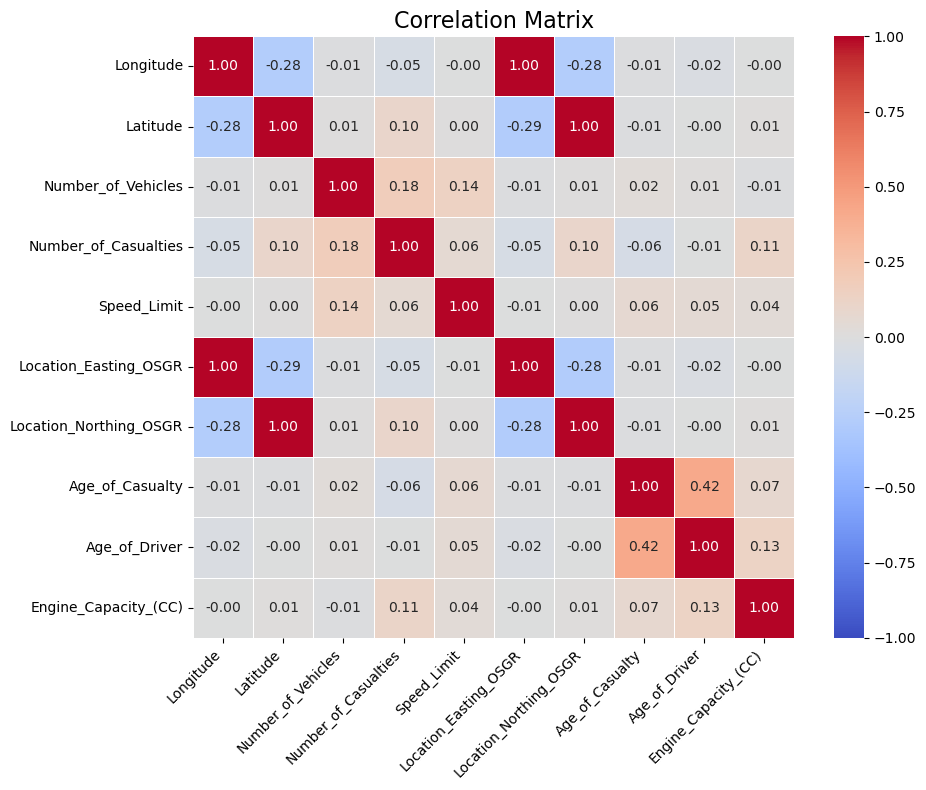

In [40]:
# 5. Calculate numerical statistics
# last error here
print("Numerical Statistics:")
stats, corr_matrix = calculate_numerical_stats(wo_onehot_df, numeric)

Creating histograms


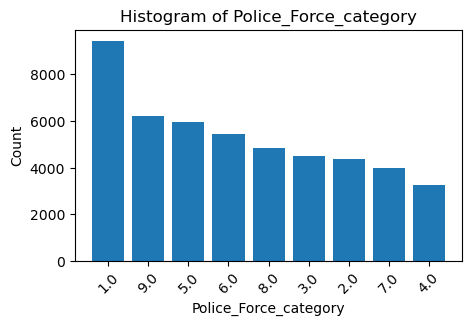

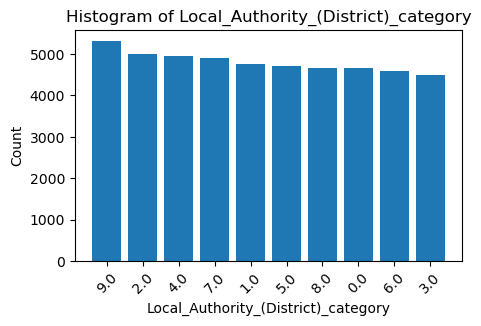

In [41]:
print("Creating histograms")
categorical_cols = [col for col in wo_onehot_df.columns 
                   if col.endswith("_category") or col in to_onehot]
create_histograms(wo_onehot_df, categorical_cols[:2])

# spark.stop()

# 3. Modelovanie - Vytvorenie popisných modelov (3b):

- Vytvorte k-means clustering model
- Pomocou vytvoreného modelu detekujte anomálie
# 4. Modelovanie - Vytvorenie klasifikačných modelov typu (aspoň jeden model každého typu)(4b):

- Decision tree model
- Linear SVM
- Naive Bayes model
- Ensembles of decision trees (Random Forests, Gradient-boosted trees)

# 5. Vyhodnotenie (3b)

- Natrénovanie klasifikačného modelu na trénovacej množine a jeho evaluáciu na testovacej množine.
- Klasifikačný model vyhodnocujte použitím kontigenčnej tabuľky a vypočítaním metrík presnosti, návratnosti, F1 a MCC (Matthews Correlation Coefficient).